Time steps: 100%|██████████| 200000/200000 [22:08:49<00:00,  2.51it/s]        


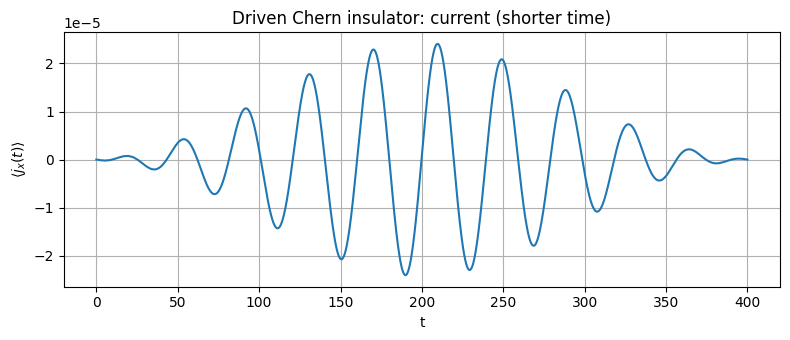

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pauli matrices
sigma_x = np.array([[0,1],[1,0]], dtype=complex)
sigma_y = np.array([[0,-1j],[1j,0]], dtype=complex)
sigma_z = np.array([[1,0],[0,-1]], dtype=complex)
identity2 = np.eye(2, dtype=complex)

# Chern insulator Hamiltonian
def H0_k(kx, ky, Delta):
    dx = np.sin(kx)
    dy = np.sin(ky)
    dz = Delta + np.cos(kx) + np.cos(ky)
    return dx*sigma_x + dy*sigma_y + dz*sigma_z

# Hamiltonian derivative for current
def dH0_dkx(kx, ky):
    return np.cos(kx)*sigma_x - np.sin(kx)*sigma_z

# Pumping field
def A_field(t, A0=0.01, Nc=10, omega0=None):
    if omega0 is None:
        omega0 = np.pi/(2*Nc)
    return A0 * np.sin(omega0*t) * (np.sin(omega0*t/(2*Nc)))**2

# Analytic 2x2 exponential
def analytic_2x2_exp(H, dt):
    h0 = 0.5*np.trace(H)
    Htr = H - h0*identity2
    E2 = 0.5*np.trace(Htr @ Htr)
    E = np.sqrt(np.real(E2))
    if E < 1e-12:
        return np.exp(-1j*h0*dt)*(identity2 - 1j*Htr*dt)
    cos_term = np.cos(E*dt)
    sin_term = np.sin(E*dt)
    Utr = cos_term*identity2 - 1j*(sin_term/E)*Htr
    return np.exp(-1j*h0*dt)*Utr

# Precompute eigenvectors and eigenvalues
def precompute_grid(Nkx=41, Nky=41, Delta=1.0):
    kx_vals = np.linspace(-np.pi, np.pi, Nkx, endpoint=False)
    ky_vals = np.linspace(-np.pi, np.pi, Nky, endpoint=False)
    U_grid = np.zeros((Nkx,Nky,2,2), dtype=complex)
    Eval_grid = np.zeros((Nkx,Nky,2), dtype=float)
    
    for ix, kx in enumerate(kx_vals):
        for iy, ky in enumerate(ky_vals):
            H = H0_k(kx, ky, Delta)
            ev, evecs = np.linalg.eigh(H)
            U_grid[ix,iy] = evecs
            Eval_grid[ix,iy] = ev
    return kx_vals, ky_vals, U_grid, Eval_grid

# Time evolution
def run_simulation(Delta=1.0, A0=0.01, Nc=10, Nkx=41, Nky=41, dt=0.002, Tfactor=1.0):
    kx_vals, ky_vals, U_grid, Eval_grid = precompute_grid(Nkx, Nky, Delta)
    omega0 = np.pi/(2*Nc)
    T = 2*np.pi*Nc/omega0 * Tfactor
    Nt = int(np.round(T/dt))
    time = np.linspace(0,T,Nt)
    j_t = np.zeros(Nt, dtype=float)
    
    # Initial density matrix in eigenbasis (lower band occupied)
    rho0 = np.array([[1.0,0],[0,0]], dtype=complex)
    
    for it, t in enumerate(tqdm(time, desc="Time steps")):
        Ax = A_field(t, A0=A0, Nc=Nc, omega0=omega0)
        j_sum = 0.0
        for ix, kx in enumerate(kx_vals):
            for iy, ky in enumerate(ky_vals):
                U = U_grid[ix,iy]
                Hshift = H0_k(kx-Ax, ky, Delta)
                dHshift = dH0_dkx(kx-Ax, ky)
                # Rotate into eigenbasis
                Htilde = U.conj().T @ Hshift @ U
                dHtilde = U.conj().T @ dHshift @ U
                jtilde = dHtilde
                # Time evolution
                U_evol = analytic_2x2_exp(Htilde, dt)
                try:
                    rho_grid
                except NameError:
                    rho_grid = np.tile(rho0, (Nkx,Nky,1,1)).astype(complex)
                rho_grid[ix,iy] = U_evol @ rho_grid[ix,iy] @ U_evol.conj().T
                j_sum += np.trace(jtilde @ rho_grid[ix,iy]).real
        j_t[it] = j_sum / (Nkx*Nky)  # simple average over BZ
    
    return time, j_t

# Run the simulation 
time, j_t = run_simulation(Delta=1.0, A0=0.01, Nc=10, Nkx=41, Nky=41, dt=0.002, Tfactor=1.0)

# Plot current
plt.figure(figsize=(8,3.5))
plt.plot(time, j_t)
plt.xlabel('t')
plt.ylabel(r'$\langle j_x(t)\rangle$')
plt.title('Driven Chern insulator: current')
plt.grid(True)
plt.tight_layout()
plt.show()
